<a href="https://colab.research.google.com/github/SamuelBM21/IC/blob/main/EEGCategorizationCNN_EOEC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch                        #PyTorch
import torch.nn as nn               #Camadas da Rede neural
import torch.optim as optim         #Otimizadores
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
import seaborn as sns
import copy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

class EEGWindowDataset(Dataset):
    def __init__(self, folder_path, subjects, tasks, sampling_points=1920, offset=35, label_map=None, transform=None):
        self.windows = []
        self.labels = []
        self.transform = transform

        for subj in subjects:
            for task in tasks:
                file_name = f"S{subj:03d}{task}.csv"
                file_path = os.path.join(folder_path, f"S{subj:03d}", file_name)

                if not os.path.exists(file_path):
                    print(f"[AVISO] Arquivo não encontrado: {file_path}")
                    continue

                data = np.loadtxt(file_path, delimiter=',')  # shape: (64, total_amostras)
                total_points = data.shape[1]

                for start in range(0, total_points - sampling_points + 1, offset):
                    end = start + sampling_points
                    window = data[:, start:end]  # shape: (64, 1920)
                    if self.transform:
                        window = self.transform(window)
                    self.windows.append(window)
                    self.labels.append(label_map[task] if label_map else 0)

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        x = torch.tensor(self.windows[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y


In [ ]:
class EEGFixedTestDataset(Dataset):
    def __init__(self, folder_path, subjects, tasks=['R01', 'R02'], sampling_points=1920, label_map=None):
        self.windows = []
        self.labels = []

        for subj in subjects:
            for task in tasks:
                file_name = f"S{subj:03d}{task}.csv"
                file_path = os.path.join(folder_path, f"S{subj:03d}", file_name)

                if not os.path.exists(file_path):
                    print(f"[AVISO] Arquivo não encontrado: {file_path}")
                    continue

                data = np.loadtxt(file_path, delimiter=',')  # shape: (64, total_amostras)
                total_points = data.shape[1]

                step = (total_points - sampling_points) // 4
                for i in range(5):
                    start = i * step
                    end = start + sampling_points
                    window = data[:, start:end]
                    self.windows.append(window)
                    self.labels.append(label_map[task] if label_map else 0)

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        x = torch.tensor(self.windows[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

In [ ]:
batch_size = 16
learning_rate = 0.001
epochs = 100

conditions = {
    0: "Eyes Opened (O)",
    1: "Eyes Closed (C)",
}


# Divisão 90% treino / 10% validação
all_subjects = list(range(1, 61))
np.random.seed(42)
np.random.shuffle(all_subjects)
test_subjects = list(range(61, 109))
train_size = int(0.9 * len(all_subjects))
train_subjects = all_subjects[:train_size]
val_subjects = all_subjects[train_size:]

label_map = {'R01': 0, 'R02': 1}

# Datasets com janelamento e offset
train_dataset = EEGWindowDataset(
    folder_path='/content/drive/MyDrive/EEGDataset/Dataset_CSV',
    subjects=train_subjects,
    tasks=['R01', 'R02'],
    sampling_points=1920,
    offset=35,
    label_map=label_map
)

val_dataset = EEGWindowDataset(
    folder_path='/content/drive/MyDrive/EEGDataset/Dataset_CSV',
    subjects=val_subjects,
    tasks=['R01', 'R02'],
    sampling_points=1920,
    offset=35,
    label_map=label_map
)

# Teste fixo (5 segmentos EC e EO por sujeito)
test_dataset = EEGFixedTestDataset(
    folder_path='/content/drive/MyDrive/EEGDataset/Dataset_CSV',
    subjects=test_subjects,
    tasks=['R01', 'R02'],
    sampling_points=1920,
    label_map=label_map
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class EEG_CNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv1d(64, 32, kernel_size=7, padding=3),   # [B, 32, 1920]
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool1d(2),                              # [B, 32, 960]


            nn.Conv1d(32, 64, kernel_size=5, padding=2),  # [B, 64, 960]
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool1d(2),                              # [B, 64, 480]

            nn.Conv1d(64, 128, kernel_size=3, padding=1), # [B, 128, 480]
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool1d(2),                              # [B, 128, 240]

            nn.Conv1d(128, 256, kernel_size=3, padding=1),# [B, 256, 240]
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool1d(2)                               # [B, 256, 120]
        )

        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.fc_layer = nn.Sequential(
            nn.Flatten(),                      # [B, 256*11]
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)        # saída = 5 classes
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.global_pool(x)
        x = self.fc_layer(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEG_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3
)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=100):
    best_f1 = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    patience, counter = 5, 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validação
        val_loss, val_f1 = evaluate_model(model, val_loader, criterion, device)
        scheduler.step(val_f1)

        print(f"Época {epoch+1}/{epochs} | Train Loss: {running_loss/len(train_loader):.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")

        # Early stopping
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Carregar melhor modelo
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(data_loader)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return avg_loss, f1

In [ ]:
def test_model(model, test_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            true_labels = labels # Use the labels directly as they are already class indices

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(true_labels.cpu().numpy())

    print("\n Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
def plot_prediction(df_test, index, model, device, class_names):
    # Extrai o sinal e o rótulo verdadeiro
    row = df_test.iloc[index, :187].values.astype(np.float32)
    true_label = int(df_test.iloc[index, 187])

    # Prepara para o modelo
    signal_tensor = torch.tensor(row).unsqueeze(0).unsqueeze(0).to(device)  # shape: [1, 1, 187]

    model.eval()
    with torch.no_grad():
        output = model(signal_tensor)
        pred_label = torch.argmax(output, dim=1).item()

    # Nome das classes
    true_name = class_names[true_label]
    pred_name = class_names[pred_label]

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(row, color='black', linewidth=1.5)
    plt.title(f"ECG Signal | True: {true_name} | Predicted: {pred_name}", fontsize=14)
    plt.xlabel("Time (ms)", fontsize=12)
    plt.ylabel("Amplitude (mV)", fontsize=12)
    plt.grid(which='both', linestyle='--', linewidth=0.5, color='red', alpha=0.3)
    plt.minorticks_on()
    plt.tight_layout()
    plt.show()

In [ ]:
model = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

Época 1/100 | Train Loss: 0.1778 | Val Loss: 0.5955 | Val F1: 0.7194
Época 2/100 | Train Loss: 0.0695 | Val Loss: 0.9495 | Val F1: 0.6995
Época 3/100 | Train Loss: 0.0515 | Val Loss: 0.8155 | Val F1: 0.7613
Época 4/100 | Train Loss: 0.0314 | Val Loss: 0.7929 | Val F1: 0.7888
Época 5/100 | Train Loss: 0.0342 | Val Loss: 0.9898 | Val F1: 0.7690
Época 6/100 | Train Loss: 0.0246 | Val Loss: 1.3549 | Val F1: 0.7278
Época 7/100 | Train Loss: 0.0198 | Val Loss: 1.0260 | Val F1: 0.7734
Época 8/100 | Train Loss: 0.0216 | Val Loss: 1.1151 | Val F1: 0.7730
Época 9/100 | Train Loss: 0.0066 | Val Loss: 1.2623 | Val F1: 0.8002
Época 10/100 | Train Loss: 0.0064 | Val Loss: 1.2306 | Val F1: 0.7806
Época 11/100 | Train Loss: 0.0060 | Val Loss: 1.0637 | Val F1: 0.8322
Época 12/100 | Train Loss: 0.0067 | Val Loss: 1.1220 | Val F1: 0.7904
Época 13/100 | Train Loss: 0.0078 | Val Loss: 1.7650 | Val F1: 0.7499
Época 14/100 | Train Loss: 0.0052 | Val Loss: 1.3267 | Val F1: 0.7797
Época 15/100 | Train Loss: 0.


 Classification Report:

                 precision    recall  f1-score   support

Eyes Opened (O)       1.00      1.00      1.00     12140
Eyes Closed (C)       1.00      1.00      1.00     12150

       accuracy                           1.00     24290
      macro avg       1.00      1.00      1.00     24290
   weighted avg       1.00      1.00      1.00     24290



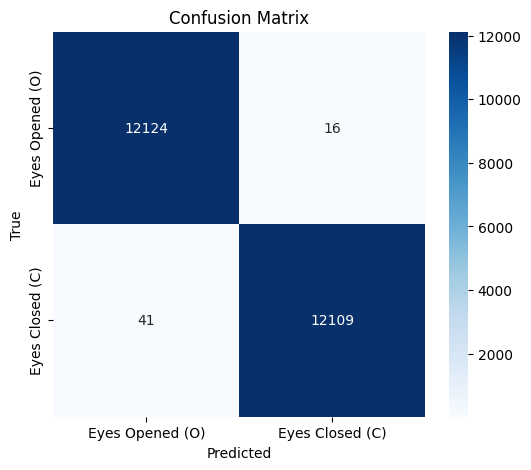

In [ ]:
test_model(model, train_loader, device, list(conditions.values()))


 Classification Report:

                 precision    recall  f1-score   support

Eyes Opened (O)       0.82      0.83      0.83       240
Eyes Closed (C)       0.83      0.82      0.82       240

       accuracy                           0.82       480
      macro avg       0.83      0.82      0.82       480
   weighted avg       0.83      0.82      0.82       480



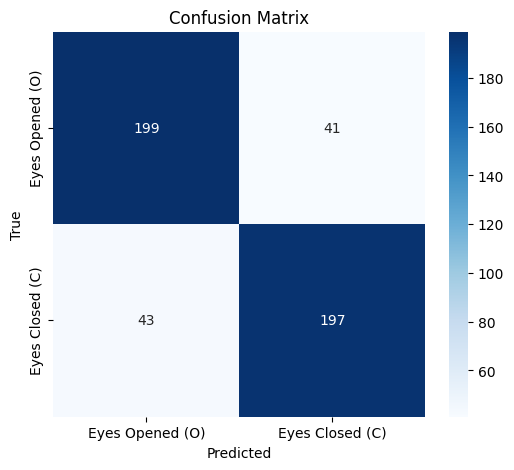

In [ ]:
test_model(model, test_loader, device, list(conditions.values()))